In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

BASE_DIR = os.getcwd().rpartition('/')[0]

In [2]:
features_df = pd.read_csv(BASE_DIR + "/Data/features.csv")
features_df.drop_duplicates(inplace=True)

labels_df = pd.read_csv(BASE_DIR + "/Data/labels.csv")
test_df = pd.read_csv(BASE_DIR + "/Data/test.csv")


features_df = features_df.merge(labels_df, on = 'trackID')
X_train = features_df[features_df.columns[:-1]]
y_train = features_df[features_df.columns[-1]]


In [3]:
## Based on the y labels, we know we have quite an imbalanced dataset

features_df['genre'].value_counts()

classic pop and rock     1684
folk                     1665
metal                    1209
soul and reggae           988
punk                      981
pop                       731
dance and electronica     523
jazz and blues            347
Name: genre, dtype: int64

In [4]:
features_df.head()

## Note: there are some NaN entries within the dataframe. 
## We will take care of it in the processing pipeline later on.

,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148,genre
0,6654,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587,44.462048,...,0.000302,0.000302,0.000315,0.000297,0.000305,0.000266,0.000225,0.130826,1.071914,folk
1,5883,Ooh Na Na,"i, you, to, and, a, me, it, not, in, my, is, y...",-4.326,141.969,3.0,6.0,0.0,236.09424,46.069761,...,0.001855,0.001920,0.001950,0.001937,0.001912,0.001836,0.001740,0.148765,0.882304,soul and reggae
2,3424,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322,40.376622,...,0.001039,0.001116,0.001166,0.001159,0.001110,0.001015,0.000895,0.116206,0.306846,soul and reggae
3,5434,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322,45.598532,...,0.000284,0.000313,0.000325,0.000324,0.000299,0.000273,0.000236,0.163738,1.247803,punk
4,516,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342,47.159148,...,0.000927,0.000994,0.001037,0.001051,0.001011,0.000962,0.000898,0.108193,0.366419,dance and electronica


## Feature Selection

- Categorical: key, mode, tags (?)
    
- Continuous: loudness, tempo, time_signature, duration, vect_1...vect_148
    
    
Since most of the ML models only accept either *categorical* OR *continuous* features, I choose to utilize only the *continuous* features since there is much more features and hence more information contained in them.

I plot the cumulative frequency distribution of some of the features listed below:


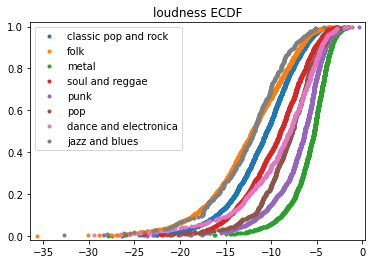

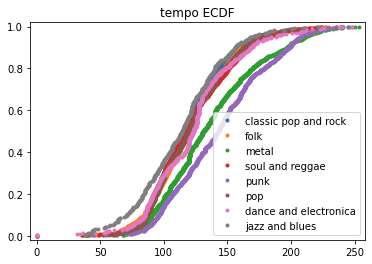

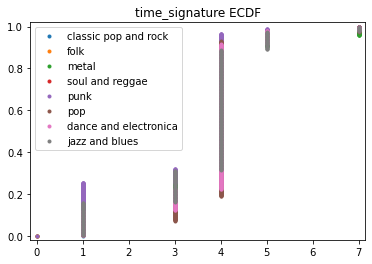

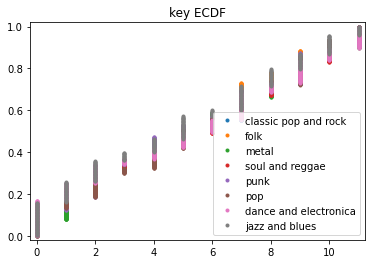

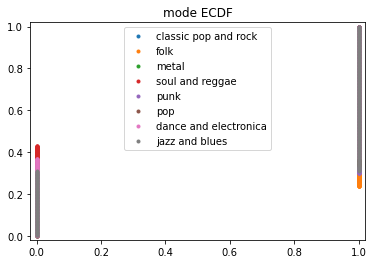

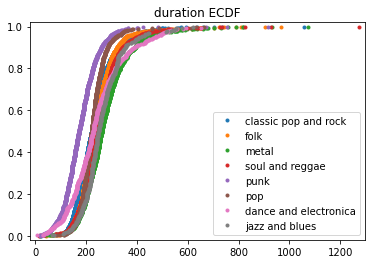

In [5]:
feature_list = ['loudness','tempo','time_signature','key','mode','duration']
genre_list = features_df['genre'].value_counts().index.tolist()


def ecdf(data):
    x_axis = np.sort(data)
    y_axis = np.arange(1,(len(data)+1))/len(data)
    return x_axis, y_axis


## Plot ECDF of various features
for feature in feature_list: # intentionally avoiding vect_1..vect_148
    for genre in genre_list:
        df = features_df[features_df['genre']==genre][feature]
        x,y = ecdf(df)
        plt.plot(x,y,linestyle='none',marker='.',label=genre)
    plt.legend()
    plt.title(f"{feature} ECDF")
    plt.margins(0.02)
    plt.show()

We observe that some of the features are:
The features values are of very different magnitudes hence they need to be scaled by either MinMaxScaler() or StandardScaler(). Outliers are quite common, hence I think the better choice is to use StandardScaler() as it anchors the Z-scores about the mean. 

In [6]:
# import sklearn functions

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, quantile_transform
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report


In [7]:
def get_models():
	models, names = list(), list()
	# LR
	models.append(LogisticRegression(max_iter=10000, tol=0.01))
	names.append('LR')
	# LDA
	models.append(LinearDiscriminantAnalysis())
	names.append('LDA')
	# SVM
	models.append(LinearSVC(max_iter=2000))
	names.append('SVM')
	# KNN
	models.append(KNeighborsClassifier(n_neighbors=5)) # n=5 is the default value
	names.append('KNN_5')
    
	return models, names

# generate a list of models
models, names = get_models() 

In [8]:
# create a list of continuous features & categorical features

vect_list = ['vect_'+str(i) for i in range(1,148+1)]
cont_features = ['loudness','tempo','time_signature','duration']
cont_features.extend(vect_list)

cat_features = ['key','mode']

In [9]:
for model,name in zip(models,names):
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), # this will fillna() with mean/median for all missing values in each column.
                                          ('scaler',StandardScaler() ) # MinMaxScaler
                                          ])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, cont_features)])
    
    pca = PCA(n_components=0.95) # using PCA @ 95% variance allows to reduce # dimensions from 152 to 42 features
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                            ('pca', pca),
                          ('classifier', model)
                          ])  
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print(f"{name} classification report:\n{classification_report(y_train, y_pred)}")

LR classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.48      0.57      0.52      1684
dance and electronica       0.53      0.31      0.40       523
                 folk       0.56      0.66      0.61      1665
       jazz and blues       0.55      0.27      0.36       347
                metal       0.83      0.86      0.84      1209
                  pop       0.45      0.31      0.37       731
                 punk       0.69      0.68      0.68       981
      soul and reggae       0.56      0.55      0.55       988

             accuracy                           0.59      8128
            macro avg       0.58      0.53      0.54      8128
         weighted avg       0.59      0.59      0.58      8128

LDA classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.45      0.57      0.50      1684
dance and electronica       0.49      0.33      0.39       52

/Users/jeremykuek/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVM classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.47      0.55      0.50      1684
dance and electronica       0.58      0.24      0.34       523
                 folk       0.53      0.70      0.60      1665
       jazz and blues       0.58      0.12      0.20       347
                metal       0.77      0.89      0.83      1209
                  pop       0.52      0.17      0.26       731
                 punk       0.65      0.64      0.65       981
      soul and reggae       0.54      0.59      0.56       988

             accuracy                           0.57      8128
            macro avg       0.58      0.49      0.49      8128
         weighted avg       0.57      0.57      0.55      8128

KNN_5 classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.61      0.82      0.70      1684
dance and electronica       0.84      0.48      0.61      

We observe the results from the training dataset classification report that the KNN model seems to outperform the rest in both accuracy and F1-score. Hence we will choose this model to be implemented for our web service.

We also note that, in general, classes with low support(count) have lower F1-scores.

In [10]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), # this will fillna() with mean/median for all missing values in each column.
                                          ('scaler',StandardScaler() ) # MinMaxScaler
                                          ])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, cont_features)])

pca = PCA(n_components=0.95) # using PCA @ 95% variance allows to reduce # dimensions from 152 to 42 features

clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('pca', pca),
                      ('classifier', model)
                      ])  

name, model = 'KNN', KNeighborsClassifier(n_neighbors=5)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
# print(f"{name} classification report:\n{classification_report(y_train, y_pred)}")

In [11]:
from joblib import dump, load

dump(clf, BASE_DIR+'/model_files/KNN_clf.joblib') 

['/Users/jeremykuek/Documents/GitHub/DBS_miniProject/model_files/KNN_clf.joblib']

In [19]:
# verify that the model clf2 can be reloaded properly and giving similar classification performance

clf2 = load(BASE_DIR+'/model_files/KNN_clf.joblib') 

y_pred2 = clf2.predict(X_train)
print(f"{name} classification report:\n{classification_report(y_train, y_pred2)}")

KNN classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.61      0.82      0.70      1684
dance and electronica       0.84      0.48      0.61       523
                 folk       0.71      0.77      0.74      1665
       jazz and blues       0.74      0.55      0.63       347
                metal       0.92      0.89      0.91      1209
                  pop       0.67      0.62      0.65       731
                 punk       0.89      0.76      0.82       981
      soul and reggae       0.78      0.64      0.70       988

             accuracy                           0.74      8128
            macro avg       0.77      0.69      0.72      8128
         weighted avg       0.76      0.74      0.74      8128



In [14]:
clf2.predict(test_df) # check that the classifier works on the test_df format

array(['classic pop and rock', 'metal', 'classic pop and rock',
       'classic pop and rock', 'soul and reggae', 'folk', 'metal', 'pop',
       'classic pop and rock', 'classic pop and rock', 'folk',
       'classic pop and rock', 'soul and reggae', 'classic pop and rock',
       'classic pop and rock', 'dance and electronica', 'folk',
       'classic pop and rock', 'metal', 'pop', 'soul and reggae',
       'classic pop and rock', 'classic pop and rock',
       'classic pop and rock', 'classic pop and rock', 'metal', 'folk',
       'soul and reggae', 'classic pop and rock', 'soul and reggae',
       'folk', 'folk', 'folk', 'metal', 'dance and electronica',
       'classic pop and rock', 'soul and reggae', 'pop',
       'classic pop and rock', 'folk', 'classic pop and rock',
       'classic pop and rock', 'classic pop and rock', 'punk',
       'classic pop and rock', 'folk', 'pop', 'folk', 'folk',
       'classic pop and rock', 'soul and reggae', 'folk', 'folk', 'folk',
       'punk', 

We will proceed to implement the KNN model in a webservice in the next phase.

In [23]:
# persist training dataset to database

import sqlite3 as sl

print(BASE_DIR)
conn = sl.connect(BASE_DIR+'/database/music_classification.db')

features_df.to_sql(name='Xy_train',
                   con=conn,
                   if_exists='fail',
                   #index=False
                  )


/Users/jeremykuek/Documents/GitHub/DBS_miniProject


In [24]:

trackTitle = test_df[['trackID','title']]
y_pred = clf2.predict(test_df)
y_pred = pd.Series(y_pred,name = 'pred_genre')
pd.concat([trackTitle,y_pred],axis=1) 

,trackID,title,pred_genre
0,6732,You Get What You Give,classic pop and rock
1,5415,Greedee,metal
2,7757,Wonderful World,classic pop and rock
3,1854,Michoacan,classic pop and rock
4,4942,HUSTLER,soul and reggae
...,...,...,...
423,186,Hablame De Frente,pop
424,4758,Jody And The Kid,folk
425,2231,Tama,soul and reggae
426,2925,Billy Dee,folk
